In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [141]:
import pandas as pd

df = pd.read_csv("../data/heart_attack_prediction_dataset.csv")

# Split blood pressure into systolic and diastolic
df[['Systolic', 'Diastolic']] = df['Blood Pressure'].str.split('/', expand=True).astype(float)

# Create ratio column
df['BP_Ratio'] = df['Systolic'] / df['Diastolic']

df['pulse_pressure'] = df['Systolic'] - df['Diastolic']
df['pulse_pressure_normalized'] = (df['pulse_pressure'] - df['pulse_pressure'].min()) / (df['pulse_pressure'].max() - df['pulse_pressure'].min())

# Convert Sex column to numeric (0 for Male, 1 for Female)
df['Sex'] = (df['Sex'] == 'Female').astype(int)

# Drop columns that are not relevant to the prediction
df = df.drop([
    'Patient ID',
    'Country',
    'Continent',
    'Hemisphere',
    'Physical Activity Days Per Week',
    'Income',
    'Blood Pressure', 
    'Systolic',
    'Diastolic',
    'pulse_pressure',
    'Diet',
    'BP_Ratio',
    'pulse_pressure_normalized',
    'Triglycerides',
    'Medication Use'
], axis=1)

# Drop any rows containing NaN values
df = df.dropna()

# Identify binary columns (those containing only 0s and 1s)
binary_columns = df.columns[(df.isin([0, 1])).all()].tolist()

# Create a list of columns to normalize (non-binary columns)
columns_to_normalize = [col for col in df.columns if col not in binary_columns + ['Heart Attack Risk']]

# Create a scaler
scaler = StandardScaler()

# Normalize the non-binary columns
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Count the number of samples in each class
risk_counts = df['Heart Attack Risk'].value_counts()

# Get the minimum count between classes
min_count = min(risk_counts)

# Create balanced dataset by randomly sampling from majority class
df_risk_0 = df[df['Heart Attack Risk'] == 0].sample(n=min_count, random_state=42)
df_risk_1 = df[df['Heart Attack Risk'] == 1].sample(n=min_count, random_state=42)

# Combine the balanced classes
df = pd.concat([df_risk_0, df_risk_1])

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

Y = df['Heart Attack Risk']

X = df.drop('Heart Attack Risk', axis=1)


X.head()

,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Previous Heart Problems,Stress Level,Sedentary Hours Per Day,BMI,Sleep Hours Per Day
0,1.566809,0,1.151674,-0.925639,1,1,1,1,1,1.510406,0,-1.563129,0.293350,-0.198660,0.491104
1,-1.492260,1,1.151674,1.361490,0,1,0,1,1,1.619492,1,-1.563129,-0.050061,0.660700,0.491104
2,-0.739258,0,-0.320030,-0.001055,0,1,1,1,1,0.026774,0,0.884887,-1.333100,1.171765,-0.514750
3,-0.880446,0,-0.926026,-0.925639,1,1,1,1,1,-0.045522,1,-1.563129,-1.037322,0.134335,-0.514750
4,1.425621,1,1.225877,-0.536341,1,0,1,0,0,-0.715329,1,0.535170,-1.546507,0.785741,0.491104


In [142]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class NeuralNetwork:
    def __init__(
        self, layer_dims, activations, learning_rate=0.01, decay=0.001, epochs=1000, 
        batch_size=32, dropout_rate=0.5, regularization=None, reg_lambda=0.01, grad_clip=1.0
    ):
        self.layer_dims = layer_dims
        self.activations = activations
        self.learning_rate = learning_rate
        self.decay = decay
        self.epochs = epochs
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate
        self.regularization = regularization
        self.reg_lambda = reg_lambda
        self.grad_clip = grad_clip
        self.params = self._initialize_params()
        
    # def _initialize_params(self):
    #     params = {}
    #     for i in range(1, len(self.layer_dims)):
    #         # He initialization for ReLU/Leaky ReLU
    #         params[f'W{i}'] = np.random.randn(self.layer_dims[i], self.layer_dims[i - 1]) * np.sqrt(2 / self.layer_dims[i - 1])
    #         params[f'b{i}'] = np.zeros((self.layer_dims[i], 1))
    #     return params
    
    def _initialize_params(self):
        params = {}
        for i in range(1, len(self.layer_dims)):
            # He initialization for weights
            if self.activations[i-1] in ["relu", "leaky_relu"]:
                # He initialization for ReLU/Leaky ReLU
                params[f'W{i}'] = np.random.randn(self.layer_dims[i], self.layer_dims[i-1]) * np.sqrt(2 / self.layer_dims[i-1])
            elif self.activations[i-1] in ["sigmoid", "tanh"]:
                # Xavier/Glorot initialization for sigmoid/tanh
                params[f'W{i}'] = np.random.randn(self.layer_dims[i], self.layer_dims[i-1]) * np.sqrt(1 / self.layer_dims[i-1])
            else:
                # Default to He initialization
                params[f'W{i}'] = np.random.randn(self.layer_dims[i], self.layer_dims[i-1]) * np.sqrt(2 / self.layer_dims[i-1])
            
            # Initialize biases to zeros
            params[f'b{i}'] = np.zeros((self.layer_dims[i], 1))
            
            # Initialize batch normalization parameters if needed
            if i < len(self.layer_dims) - 1:  # Skip for output layer
                params[f'gamma{i}'] = np.ones((self.layer_dims[i], 1))
                params[f'beta{i}'] = np.zeros((self.layer_dims[i], 1))
                
        return params

    def _activation_forward(self, Z, activation):
        if activation == "relu":
            return np.maximum(0, Z)
        elif activation == "leaky_relu":
            return np.where(Z > 0, Z, 0.01 * Z)
        elif activation == "sigmoid":
            return 1 / (1 + np.exp(-Z))
        elif activation == "tanh":
            return np.tanh(Z)

    def _activation_backward(self, dA, Z, activation):
        if activation == "relu":
            dZ = np.array(dA, copy=True)
            dZ[Z <= 0] = 0
            return dZ
        elif activation == "leaky_relu":
            dZ = np.where(Z > 0, dA, dA * 0.01)
            return dZ
        elif activation == "sigmoid":
            s = 1 / (1 + np.exp(-Z))
            return dA * s * (1 - s)
        elif activation == "tanh":
            t = np.tanh(Z)
            return dA * (1 - t ** 2)

    def _batch_norm(self, Z, layer_index):
        mean = np.mean(Z, axis=1, keepdims=True)
        variance = np.var(Z, axis=1, keepdims=True)
        Z_norm = (Z - mean) / np.sqrt(variance + 1e-8)
        
        # Trainable scale (gamma) and shift (beta) for each layer
        if f'gamma{layer_index}' not in self.params:
            self.params[f'gamma{layer_index}'] = np.ones((Z.shape[0], 1))
            self.params[f'beta{layer_index}'] = np.zeros((Z.shape[0], 1))
        
        Z_out = self.params[f'gamma{layer_index}'] * Z_norm + self.params[f'beta{layer_index}']
        return Z_out

    def _forward(self, X, track_activations=False):
        cache = {'A0': X}
        activations = [] if track_activations else None
        
        for i in range(1, len(self.layer_dims)):
            W = self.params[f'W{i}']
            b = self.params[f'b{i}']
            A_prev = cache[f'A{i-1}']
            Z = np.dot(W, A_prev) + b

            if i < len(self.layer_dims) - 1:  # Skip batch norm for output layer
                Z = self._batch_norm(Z, i)
            
            A = self._activation_forward(Z, self.activations[i-1])
            
            # Apply dropout to hidden layers
            if i < len(self.layer_dims) - 1 and self.dropout_rate > 0:
                dropout_mask = np.random.rand(*A.shape) > self.dropout_rate
                A *= dropout_mask / (1 - self.dropout_rate)
                cache[f'D{i}'] = dropout_mask

            if track_activations:
                activations.append(A)
                
            cache[f'Z{i}'] = Z
            cache[f'A{i}'] = A

        return cache[f'A{len(self.layer_dims) - 1}'], cache, activations

    def _backward(self, A_last, Y, cache):
        m = A_last.shape[1]
        grads = {}
        dA_prev = A_last - Y

        for i in range(len(self.layer_dims) - 1, 0, -1):
            A_prev = cache[f'A{i-1}']
            Z = cache[f'Z{i}']
            W = self.params[f'W{i}']

            dZ = self._activation_backward(dA_prev, Z, self.activations[i-1])
            grads[f'dW{i}'] = (1 / m) * np.dot(dZ, A_prev.T)
            grads[f'db{i}'] = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
            dA_prev = np.dot(W.T, dZ)

            if self.regularization == "L2":
                grads[f'dW{i}'] += (self.reg_lambda / m) * W

            # Gradient clipping
            grads[f'dW{i}'] = np.clip(grads[f'dW{i}'], -self.grad_clip, self.grad_clip)
            grads[f'db{i}'] = np.clip(grads[f'db{i}'], -self.grad_clip, self.grad_clip)

        return grads

    def _update_params(self, grads):
        for i in range(1, len(self.layer_dims)):
            self.params[f'W{i}'] -= self.learning_rate * grads[f'dW{i}']
            self.params[f'b{i}'] -= self.learning_rate * grads[f'db{i}']

    def compute_loss(self, Y, A_last, class_weights={0: 1.0, 1: 1.8}):
        m = Y.shape[1]
        loss = -(class_weights[1] * Y * np.log(A_last + 1e-8) + class_weights[0] * (1 - Y) * np.log(1 - A_last + 1e-8))
        return np.sum(loss) / m

    def train(self, X, Y, X_val=None, Y_val=None, patience=50):
        best_val_accuracy = 0
        patience_counter = 0
        initial_learning_rate = self.learning_rate
        losses = []

        for epoch in range(self.epochs):
            self.learning_rate = initial_learning_rate * (1 / (1 + self.decay * epoch))
            A_last, cache, _ = self._forward(X)
            loss = self.compute_loss(Y, A_last)
            losses.append(loss)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}, Learning Rate: {self.learning_rate:.6f}")
            
            grads = self._backward(A_last, Y, cache)
            self._update_params(grads)
            
            # Early stopping
            if X_val is not None and Y_val is not None:
                val_predictions = self.predict(X_val)
                val_accuracy = np.mean(val_predictions == Y_val)

                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    patience_counter = 0
                else:
                    patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
        
        # Plot loss curve
        plt.plot(losses)
        plt.title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

    def predict(self, X):
        A_last, _, _ = self._forward(X)
        return (A_last > 0.5).astype(int)

    def visualize_activations(self, activations):
        for i, activation in enumerate(activations, 1):
            plt.figure(figsize=(10, 4))
            plt.hist(activation.flatten(), bins=30, alpha=0.6, color='b')
            plt.title(f'Activation Distribution at Layer {i}')
            plt.xlabel('Activation Value')
            plt.ylabel('Frequency')
            plt.show()

Epoch 0, Loss: 1.1295, Learning Rate: 0.100000
Epoch 100, Loss: 1.0455, Learning Rate: 0.090909
Epoch 200, Loss: 1.0109, Learning Rate: 0.083333
Epoch 300, Loss: 0.9967, Learning Rate: 0.076923
Epoch 400, Loss: 0.9855, Learning Rate: 0.071429
Epoch 500, Loss: 0.9789, Learning Rate: 0.066667
Epoch 600, Loss: 0.9732, Learning Rate: 0.062500
Epoch 700, Loss: 0.9730, Learning Rate: 0.058824
Epoch 800, Loss: 0.9727, Learning Rate: 0.055556
Epoch 900, Loss: 0.9711, Learning Rate: 0.052632


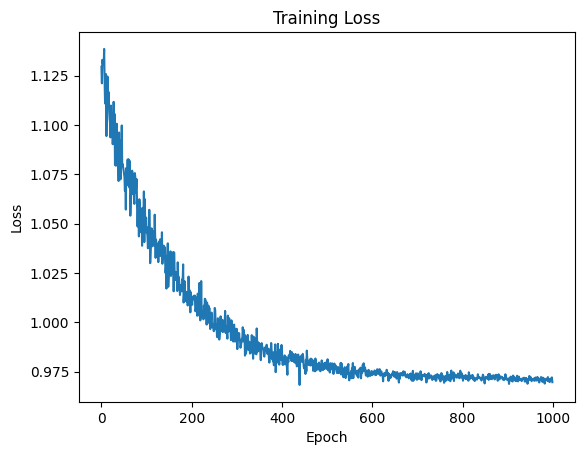

In [143]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Ensure labels are reshaped properly if necessary
# Convert labels to numpy arrays and reshape for binary classification
y_train_binary = y_train.to_numpy().reshape(1, -1)
y_test_binary = y_test.to_numpy().reshape(1, -1)

# Initialize and train the neural network with ReLU and sigmoid activations
nn = NeuralNetwork(
    layer_dims=[X_train.shape[1], 512, 256, 128, 64, 1],
    activations=['relu', 'relu', 'relu', 'relu', 'sigmoid'],
    learning_rate=0.1,
    epochs=1000,
    dropout_rate=0.5,
    regularization="L2",
    reg_lambda=0.01,
    batch_size=16
)

# Train the model
nn.train(X_train.T, y_train_binary)
# print(nn.params)



Training Accuracy: 0.5277
Testing Accuracy: 0.4849


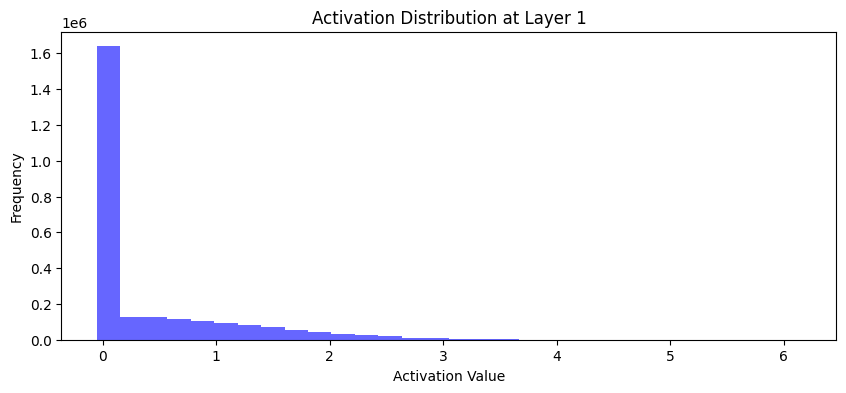

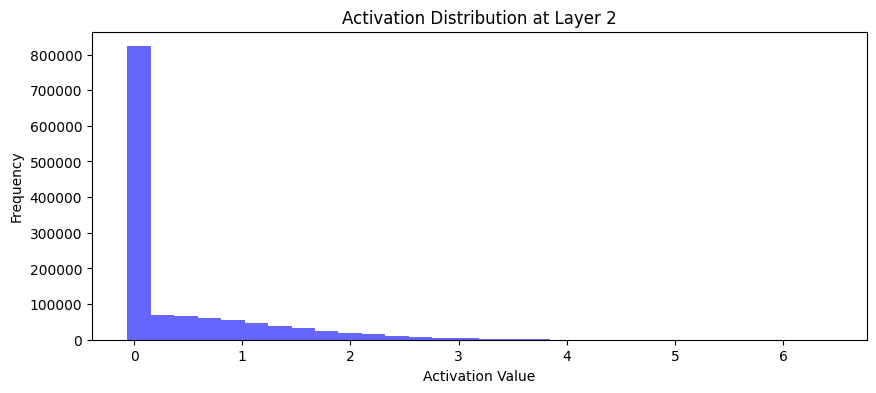

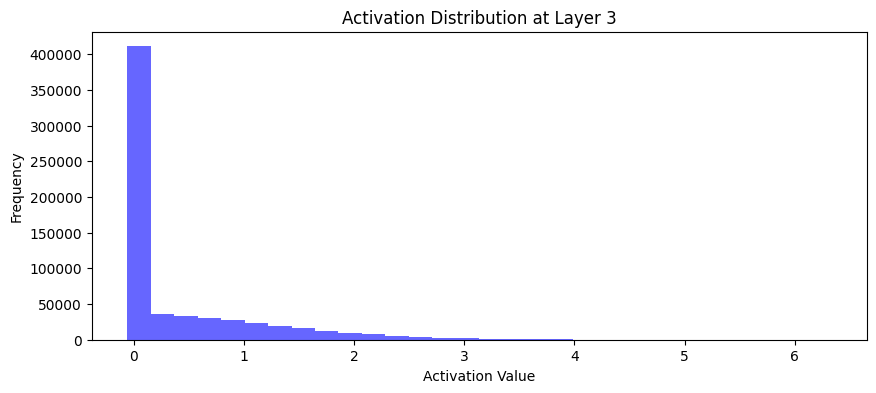

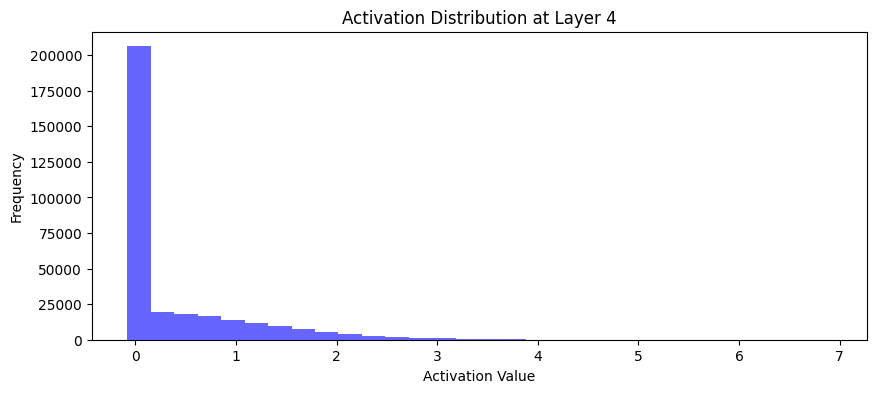

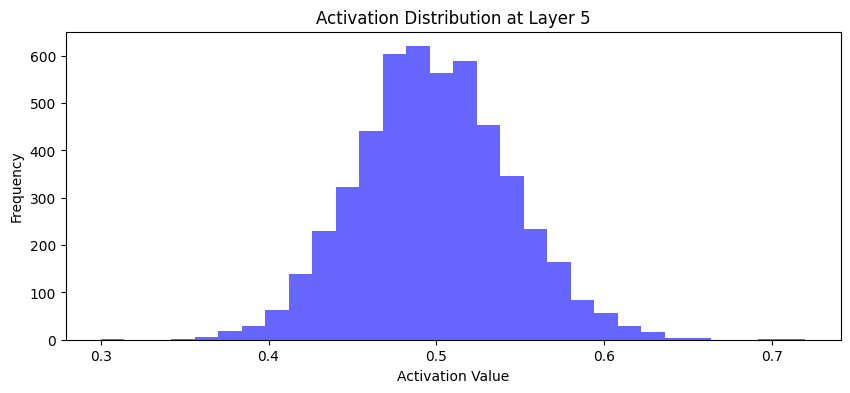

In [139]:
# Make predictions and calculate accuracies
train_predictions = nn.predict(X_train.T)
test_predictions = nn.predict(X_test.T)

train_accuracy = np.mean(train_predictions == y_train_binary.flatten())
test_accuracy = np.mean(test_predictions == y_test_binary.flatten())

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Forward pass with activation tracking
_, _, activations = nn._forward(X_train.T, track_activations=True)

# Visualize activations
nn.visualize_activations(activations)
